In [1]:
import numpy as np
import pickle as pk
    
test_data_path = "test_data.pk"
pred_path = "X_pred.pk"

In [2]:
X_pred = pk.load(open(pred_path, "rb"))
X_pred[0].shape

2024-01-17 13:55:57.698610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([11, 321])

In [3]:
import pickle as pk

test_data = pk.load(open(test_data_path, "rb"))
X_test = test_data["X"][:len(X_pred)]
alphabet_size = test_data["alphabet_size"]

y_test = test_data["y"][:len(X_pred)]
event_mapping = test_data["event_mapping"]

len(X_test), len(y_test), np.unique(y_test, return_counts=True)

(15001, 15001, (array([0, 1]), array([7927, 7074])))

In [4]:
import copy

probabilities = list()
for pred_seq, true_seq in zip(X_pred, X_test):
    current_probs = list()

    x_tgt = np.zeros((len(true_seq)+1, alphabet_size))
    for i, x in enumerate(true_seq):
        x_tgt[i, x] = 1
    x_tgt[-1, event_mapping["<EOS>"]] = 1

    #print(pred_seq.shape)
    #print(x_tgt.shape)
    
    for p_oh, t_oh in zip(pred_seq, x_tgt): 
        #pred_partion = np.argpartition(pred_seq, len(pred_seq) - top_k)[-top_k:]
        true_next_symbol = np.argmax(t_oh)
        true_next_symbol_p = np.max(t_oh)
        pred_next_symbol_p = p_oh[true_next_symbol]

        #print(true_next_symbol, true_next_symbol_p, pred_next_symbol_p, np.max(p_oh), np.argmax(p_oh))
        #break

        current_probs.append(abs(true_next_symbol_p - pred_next_symbol_p))
    probabilities.append(current_probs)
    #break
print(len(probabilities))

15001


In [5]:
current_labels = y_test[:len(probabilities)]
len(current_labels)

15001

In [6]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([7927, 7074]))

In [7]:
# mean, min
mean_score = list()
min_score = list()
max_score = list()
sum_score = list()
for p in probabilities:
    p = np.array(p)
    mean_score.append(np.mean(p))
    min_score.append(np.min(p))
    max_score.append(np.max(p))
    sum_score.append(np.sum(p))

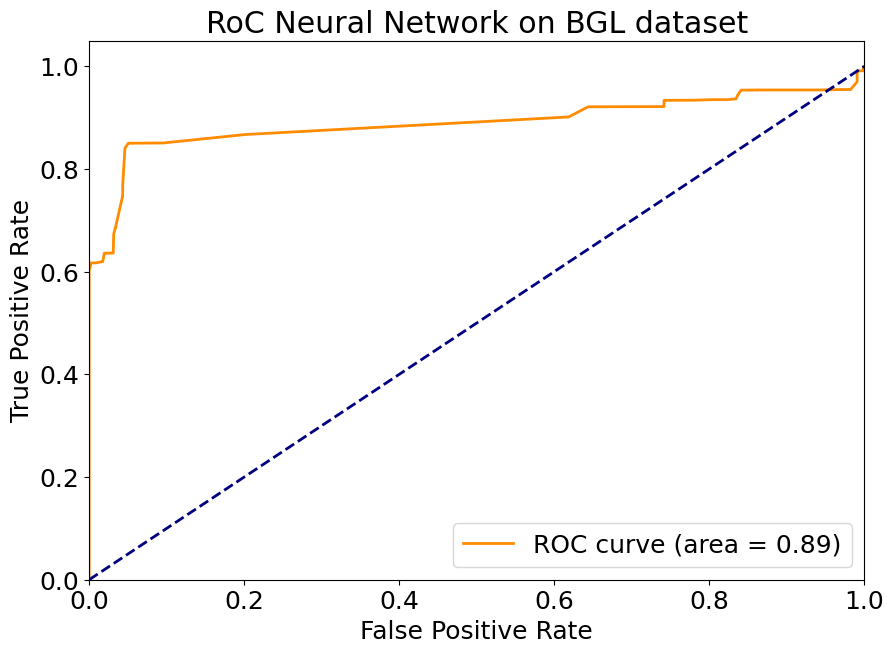

In [11]:
import matplotlib

matplotlib.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_curve, auc, roc_auc_score

score = min_score

fpr, tpr, thresholds = roc_curve(current_labels, score)
roc_auc = roc_auc_score(current_labels, score)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RoC Neural Network on BGL dataset")
plt.legend(loc="lower right")

plt.savefig("roc_network_bgl.png")